In [1]:
# using tf 2.0
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tqdm.notebook import tqdm as tqdm
import itertools
from sklearn.model_selection import train_test_split
# Import hand craft scripts
import def_model
import data_gen

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth( device=gpu, enable=True)

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train,x_val,y_train,y_val=train_test_split(x_train, y_train, test_size=len(y_train)//10*2)

In [3]:
way =10
max_epoch = 40
BATCH_SIZE=128
gen_train=data_gen.DataGenerator(x_train,y_train,way,batch_size=BATCH_SIZE,shuffle=True)
gen_val=data_gen.DataGenerator(x_val,y_val,way,batch_size=BATCH_SIZE,shuffle=False)
len(gen_train), len(gen_val)

(375, 93)

(128, 28, 28, 1) (128, 10)


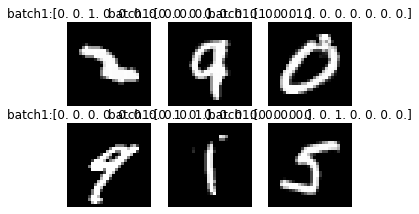

In [4]:
for batch_data,batch_label in gen_train:
    break
print(batch_data.shape,batch_label.shape)
gp,ee,n_row,n_col=1,1,2,3
plt.figure(figsize=(n_col*1.7,n_row*1.7))
for ii in range(n_row):
    for jj in range(n_col):
        plt.subplot(n_row,n_col,ee);plt.axis('off');plt.title(f"batch{gp}:{batch_label[ee]}")
        plt.imshow(batch_data[ee,...,0],"gray")
        ee+=1
plt.show()

In [5]:
N_FILTER=32
cnn=def_model.cnn_model(way,N_FILTER)

cnn_loss_fn=keras.losses.categorical_crossentropy
# lstm_loss_fn=keras.losses.mae
acc_fn = keras.metrics.categorical_accuracy

## There are 11k parameters to update

layer idx: w:(3, 3, 1, 32) + b: (32,) = 320
layer idx: w:(1, 1, 32, 16) + b: (16,) = 528
layer idx: w:(3, 3, 16, 32) + b: (32,) = 4640
layer idx: w:(1, 1, 32, 16) + b: (16,) = 528
layer idx: w:(3, 3, 16, 32) + b: (32,) = 4640
layer idx: w:(1, 1, 32, 16) + b: (16,) = 528
layer idx: w:(16, 10) + b: (10,) = 170
totla 11354 parameters


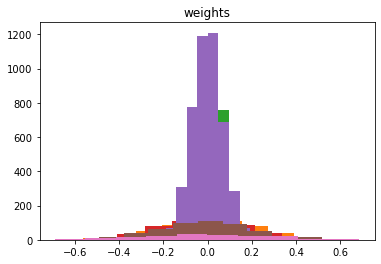

In [6]:
cnn.print_shape()
for ii in [cnn.cnn1,cnn.cnn1_1,cnn.cnn2,cnn.cnn2_1,cnn.cnn3,cnn.cnn3_1,cnn.dense]:
    plt.hist(np.reshape(ii.w.numpy(),-1))
plt.title("weights")
plt.show()

In [7]:
def flat_tensors(mdl):
    tensors=tf.concat([tf.reshape(ww,[-1]) for ww in mdl],axis=0)
    return tf.reshape(tensors,(len(tensors),1,1))
lr=0.001

cnn_param_num=sum([np.prod(ww.shape) for ww in cnn.trainable_weights()])
cnn_loss_fn=keras.losses.categorical_crossentropy
acc_fn = keras.metrics.categorical_accuracy

In [13]:
best_loss=np.Inf
count=0
for epoch in range(max_epoch):
    train_sess=tqdm(gen_train)
    train_acc=[]    
    for data,label_1_hot in train_sess:
        count=count+1
        with tf.GradientTape() as tape:
            logits=cnn(data)
            loss1=cnn_loss_fn(label_1_hot, logits)
#             +tf.sqrt(tf.reduce_mean(new_update**2))*0.5
        grads_cnn=tape.gradient(loss1,cnn.trainable_weights())
        cnn.assign_update(flat_tensors(grads_cnn)*lr)
        acc=acc_fn(label_1_hot,logits).numpy().mean()
        train_acc.append(acc)
        train_sess.set_postfix({"CNN loss": loss1.numpy().mean(),"acc":np.mean(train_acc)})
    val_acc=[]
    val_loss=[]
    for data,label_1_hot in gen_val:
#         label_1_hot = tf.one_hot(tf.cast(label, tf.int32),depth=way)
        logits=cnn(data)
        loss1=cnn_loss_fn(label_1_hot, logits).numpy()
        acc=acc_fn(label_1_hot,logits).numpy().mean()
        val_loss.append(loss1)
        val_acc.append(acc)
    print(f"CNN val: loss: {np.mean(val_loss):.08f},acc: {np.mean(val_acc):.02f},lr: {lr}")
    if best_loss<np.mean(val_loss):
        break
    else:
        best_loss=np.mean(val_loss)
#     lr=lr*0.1
#     opt_cnn=keras.optimizers.Adam(lr=lr)


CNN val: loss: 0.13870695,acc: 0.96,lr: 0.001



CNN val: loss: 0.13435678,acc: 0.96,lr: 0.001



CNN val: loss: 0.11681845,acc: 0.97,lr: 0.001



CNN val: loss: 0.11540029,acc: 0.97,lr: 0.001



CNN val: loss: 0.10208923,acc: 0.97,lr: 0.001



CNN val: loss: 0.09763445,acc: 0.97,lr: 0.001



CNN val: loss: 0.10191697,acc: 0.97,lr: 0.001
